# Notebook 1 - Simple Analyzer

This notebook takes CMS OpenData nanoAOD files, applies some selection and make few simple plots. 

Expected output: Histograms with the event selection.


Physics objects of interest: muons and jets. 

For more information: https://github.com/HEP-EPN/FourTopsCMSOpenData/wiki. 

To understand more about coffea (extremely useful): https://coffeateam.github.io/coffea/index.html. 

Let's first load the libraries:

In [1]:
import asyncio
import logging
import os
import time

import vector; vector.register_awkward() 
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

For future use, let's define some global configuration

In [3]:
#ifile = uproot.open("root://eosuser.cern.ch//eos/user/a/algomez/tmpFiles/opendata_files/SingleElectron/cmsopendata2015_Run2015D_SingleElectron_MINIAOD_08Jun2016-v1_21.root")
#ifile["Events"].keys()

#events = NanoEventsFactory.from_root(
#    "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root",
#    schemaclass=NanoAODSchema.v6,
#    metadata={"dataset": "TT"},
#).events()

In [2]:
DATA = "SingleMuon"  

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 10

### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 500_000

# metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 4

NanoAOD datasets are stored in `data/ntuples_nanoaod.json` folder. This json file contains information about the number of events, process and systematic. The following function reads the json file and returns a dictionary with the process to run.

In [7]:
def construct_fileset(n_files_max_per_sample,
                      dataset="SingleMuon",
                      onlyNominal=False,
                      ntuples_json="ntuples_nanoaod.json"):
    # using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
    # for reference
    # x-secs are in pb
    xsec_info = {
        "ttbar": 831., ###396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
       # "single_top_s_chan": 2.0268 + 1.2676,
       # "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
       # "single_top_tW": 35.6 + 35.6, #37.936 + 37.906,
       # "wjets": 61526, ##61457 * 0.252,  # e/mu+nu final states
        "tttt" : 0.009, 
        "data": None
    }

    # list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)
    
    # process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            file_list = file_info[process][dataset]["files"]
            if n_files_max_per_sample != -1:
                #file_list = file_list[:int(n_files_max_per_sample/10)]
                file_list = file_list[:]  # use all data

            file_paths = [f["path"] for f in file_list]
            metadata = {"process": "data", "xsec": 1}
            fileset.update({"data": {"files": file_paths, "metadata": metadata}})
            

        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            #print(variation)
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples, first 10 files

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})
            

    return fileset


In [8]:
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, dataset=DATA,
                            onlyNominal=True, ntuples_json='../Tesis/ntuples_nanoaod.json') 

print(fileset["ttbar__nominal"]["metadata"]["nevts"])
print(fileset["tttt__nominal"]["metadata"]["nevts"])
#print(fileset["wjets__nominal"]["metadata"]["nevts"])
#print(fileset["data"]["files"])
#print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
#print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")
#print(f"\nexample of data information in fileset:\n{{\n  'files': [{fileset['data']['files'][0]}, ...],")

11378043
1210521


In [5]:
data_files = fileset["data"]["files"]

# Loop over the files and count the number of events in each one
nevents = 0
for data_file in data_files:
    with uproot.open(data_file) as rootfile:
        # Get the number of events in the "Events" TTree
        tree = rootfile["Events"]
        #print(len(tree))
        nevents += len(tree)

print(f"Total number of events: {nevents}")

Total number of events: 32938


## Analyzer

Here is the main analyzer. Uses coffea/awkward to make the analysis.

Advice: to understand how the selection is working, print the different arrays before and after the selections are made.

In [18]:
class fourTopAnalysis(processor.ProcessorABC):
    def __init__(self, DATASET):
        
        self.DATASET = DATASET
        
        ### booking histograms
        ## define categories
        process_cat = hist.axis.StrCategory([], name="process", label="Process", growth=True)
        variation_cat  = hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True)
        
        ## define bins (axis)
        pt_axis = hist.axis.Regular( bins=500, start=0, stop=500, name="var")
        eta_axis = hist.axis.Regular( bins=40, start=-5, stop=5, name="var")
        num_axis = hist.axis.Regular( bins=10, start=0, stop=20, name="var")
        #Htb
        htb_axis=hist.axis.Regular( bins=20, start=0, stop=1000, name="var")
        #Htratio
        htrat_axis=hist.axis.Regular(bins=50,start=0, stop=1, name="var")
        #3rd-highest CSV
        csv_axis=hist.axis.Regular(bins=40,start=0, stop=1, name="var")
        
        
        
        ## define a dictionary of histograms
        self.hist_muon_dict = {
            'muon_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'muon_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'nmuons'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'njets'    : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())), 
            'nbjets'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'htb'      : (hist.Hist(htb_axis, process_cat, variation_cat, storage=hist.storage.Weight())), #variable for bdt
            'htrat'    : (hist.Hist(htrat_axis, process_cat, variation_cat, storage=hist.storage.Weight())), #variable for bdt
            'third_highest_csv': (hist.Hist(csv_axis, process_cat, variation_cat, storage=hist.storage.Weight())) #variable for bdt

        }
        
        sumw_dict = {'sumw': processor.defaultdict_accumulator(float)
        }
        

    def process(self, events):

        hists = self.hist_muon_dict.copy()

        process = events.metadata["process"]  # "ttbar" etc.

    
        if process != "data":
            # normalization for MC
            x_sec = events.metadata["xsec"]
            nevts_total = events.metadata["nevts"]
            lumi = 2256.38 # /pb integrated luminosity
            xsec_weight = x_sec * lumi / nevts_total #L*cross-section/N
        else:
            xsec_weight = 1

        events["pt_nominal"] = 1.0

        ### OBJECT SELECTION
        
        # Object selection: Muon (Tight - muon id definition in nanoAOD does not work, have to define manual)
        
        muon_is_global= events.Muon.isGlobal == True
        muon_is_tracker= events.Muon.isTracker == True
        
        loose_muon_selection= (events.Muon.pt > 10) & (abs(events.Muon.eta)<2.5) & (events.Muon.pfRelIso04_all < 0.25) & (muon_is_global | muon_is_tracker)
        selected_muon_selection = (events.Muon.pt > 26) & (abs(events.Muon.eta)<2.1) & (events.Muon.nTrackerLayers > 5) & (events.Muon.nStations > 0) & (abs(events.Muon.dxy) < 0.2) & (abs(events.Muon.dz) < 0.5) & (events.Muon.pfRelIso04_all < .15) & (muon_is_global & muon_is_tracker)
                # [[muon 1], [muon 1, muon 2],..]
                
        selected_muons=events.Muon[(loose_muon_selection & selected_muon_selection)]
        selected_muon= ak.count(selected_muons.pt, axis=1)==1 
        
        veto_muons=events.Muon[(loose_muon_selection & ~selected_muon_selection)] #  veto additional lose muon
        veto_muon= ak.count(veto_muons.pt, axis=1)== 0
        
        #Object selection: Jets
        selected_leptons = selected_muons 
        jet_selection = (events.Jet.pt * events["pt_nominal"] > 30) & (abs(events.Jet.eta) < 2.5) & (events.Jet.jetId > 1)
        selected_jets = events.Jet[jet_selection]
        nearest_lepton = selected_jets.nearest(selected_leptons, threshold=.4)
        selected_jets = selected_jets[ ~ak.is_none(nearest_lepton) ]
        
        ## the results of these 2 lines should be equivalent to the 2 lines above
        #lepton_mask = ak.any(selected_jets.metric_table(selected_lepton, metric=lambda j, e: ak.local_index(j, axis=1) == e.jetIdx,), axis=2)
        #selected_jets = selected_jets[~lepton_mask]
        
        selected_bjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & (events.Jet.btagCSVV2 >=0.8)]
        selected_jets_nobjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & ~(events.Jet.btagCSVV2 >=0.8)]  ### this we might use it later
        
       ################
        #### Event Selection
        ################
        
        if self.DATASET.endswith("Muon"):
            # trigger
            event_filters = ( events.HLT.IsoMu18 == 1 )  #trigger selection (1 value per event)
            selected_lepton = selected_muon
            veto_lepton = veto_muon

        event_filters = event_filters & ( selected_lepton & veto_lepton )
        # at least four jets
        event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means score above threshold)
        event_filters = event_filters & (ak.sum(selected_bjets) >= 1)
        #print(event_filters)
        
        # apply event filters
        selected_events = events[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]
        selected_bjets = selected_bjets[event_filters]
        
        ##### VARIABLES FOR BDT ####
        
        #### Calculate HTb
        htb = ak.sum(selected_bjets.pt, axis=1)
        
        #### Calculate H_t^ratio
        
        # Calculate HT of the four highest-pT jets
        top4_jets = ak.argsort(selected_jets.pt, axis=1)[:, :4]  # Select the four highest-pT jets
        ht_top4 = ak.sum(top4_jets, axis=1)
        
        # Calculate HT of the other jets in the event
        other_jets = ak.argsort(selected_jets.pt, axis=1)[:, 4:]  # Select the remaining jets
        ht_other = ak.sum(other_jets, axis=1)
        
        ht_ratio = np.where(ht_other != 0, ht_top4 / ht_other, -1)
        
        #### Calculate Third-highest CSV
        
        jet_csv_values = selected_jets.btagCSVV2  # Extract CSV values for all jets in the event
        third_highest_csv = ak.argsort(jet_csv_values, axis=1)[:, 2]
        
        for ivar in [ "pt", "eta" ]:
            hists[f'muon_{ivar}'].fill(
                        var=ak.flatten(getattr(selected_muons, ivar)), process=process, variation="nominal", weight=xsec_weight)
            hists[f'jets_{ivar}'].fill(
                        var=ak.flatten(getattr(selected_jets, ivar)), process=process, variation="nominal", weight=xsec_weight)
            hists['nmuons'].fill(var=ak.count(selected_muons.pt, axis=1), process=process, variation="nominal", weight=xsec_weight)
            hists['njets'].fill(var=ak.count(selected_jets.pt, axis=1), process=process, variation="nominal", weight=xsec_weight)
            hists['nbjets'].fill(var=ak.count(selected_bjets.pt, axis=1), process=process,variation="nominal", weight=xsec_weight)
            hists['htb'].fill(var=htb, process=process, variation="nominal", weight=xsec_weight)
            hists['htrat'].fill(var=ht_ratio, process=process, variation="nominal", weight=xsec_weight)
            hists['third_highest_csv'].fill(var=third_highest_csv, process=process, variation="nominal", weight=xsec_weight)
     
            output = {"nevents": {events.metadata["dataset"]: len(events)}, "hists" : hists}

            return output

    def postprocess(self, accumulator):
        return accumulator

Let's make it run:

In [19]:
executor = processor.FuturesExecutor(workers=NUM_CORES)

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)
t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=fourTopAnalysis(DATASET=DATA))
exec_time = time.monotonic() - t0

Preprocessing:   0%|          | 0/56 [00:00<?, ?file/s]

Processing:   0%|          | 0/69 [00:00<?, ?chunk/s]

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/

In [20]:
tttt_nevts = fileset["tttt__nominal"]["metadata"]["nevts"]
print(tttt_nevts)

1210521


In [21]:
ttbar_nevts = fileset["ttbar__nominal"]["metadata"]["nevts"]
print(ttbar_nevts)

11378043


In [22]:
import pickle

with open("histograms.pkl", "wb") as f:
    pickle.dump(all_histograms["hists"], f, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
dataset_source = "/data" if fileset["ttbar__nominal"]["files"][0].startswith("/data") else "https://xrootd-local.unl.edu:1094" # TODO: xcache support
metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "dataset_source": dataset_source, 
                "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, 
                "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE})#

print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717


event rate per worker (full execution time divided by NUM_CORES=4): 2.84 kHz
event rate per worker (pure processtime): 3.22 kHz
amount of data read: 6709.93 MB


## Plots

Finally, let's make some simple plots:

In [24]:
import os
import time

import hist
import json
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import ratio_uncertainty
import matplotlib as mpl
import numpy as np
import pickle
from collections import OrderedDict

In [25]:
with open("histograms.pkl", "rb") as f:
    h2 = pickle.load(f)
    print(h2.keys())

dict_keys(['jets_pt', 'muon_eta', 'htb', 'nbjets', 'muon_pt', 'third_highest_csv', 'jets_eta', 'htrat', 'njets', 'nmuons'])


In [26]:
### list of bkgs to plot
dictBkgs = OrderedDict()
dictBkgs["ttbar"] = { "color" : "red", "label" : "$t\\bar{t}$" }
#dictBkgs["wjets"] = { "color" : "blue", "label" : "EW" }
#dictBkgs["single_top_s_chan"] = { "color" : "green", "label" : "t s-channel" }
#dictBkgs["single_top_t_chan"] = { "color" : "lightgreen", "label" : "t t-channel" }
#dictBkgs["single_top_tW"] = { "color" : "darkgreen", "label" : "tW" }

bkgs = list(dictBkgs.keys())[::-1]
print(bkgs)
bkgs_colors = [ col["color"] for i, col in dictBkgs.items() ]
print(bkgs_colors)
bkgs_label = [ col["label"] for i, col in dictBkgs.items() ]

['ttbar']
['red']


In [28]:
### Run this cell twice to load the CMS style properly
def plotHisto( histName = "muon_pt", xlabel = "Leading Muon $p_{T}$ [GeV]", rebinFactor = 7, 
                  xmin = 20j, xmax = 300j, mcFactor = 0.05, xlog=False):

    data = h2[histName][ xmin:xmax:hist.rebin(rebinFactor), "data", "nominal"]
    hists = [] 
    tot = data.copy()
    tot.reset()
    for ibkg in bkgs:
        hists.append( (mcFactor*h2[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"]) )
        tot += (mcFactor*h2[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"])
    signal = 20*h2[histName][ xmin:xmax:hist.rebin(rebinFactor), "tttt", "nominal"]
    

    fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.03), sharex=True)
    hep.cms.label("Open Data", ax=ax, data=True, lumi=2.6, year=2015) #, rlabel="2.3 $\mathrm{fb^{-1}}$, 2015 (8 TeV)")
    plt.style.use(hep.style.CMS)

    hep.histplot(data, ax=ax, histtype='errorbar', color='k', capsize=4, yerr=True, label="Data")
    hep.histplot(hists, ax=ax, stack=True, histtype='fill',color=["red"],label=bkgs)
    hep.histplot(signal, ax=ax, histtype='step', color='lightgray', label="$ \\bar{t}t\\bar{t} (x20) $")

    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.4}
    ax.stairs(
        values=tot.values() + np.sqrt(tot.values()),
        baseline=tot.values() - np.sqrt(tot.values()),
        edges=data.axes[0].edges, **errps, label='Stat. unc.')
    ax.set_yscale("log")
    ax.set_ylim(0.1, 10e7)
    ax.legend()
    ax.set_ylabel(f"Events / {rebinFactor}")
    
    yerr = ratio_uncertainty(data.values(), tot.values(), 'poisson')
    rax.stairs(1+yerr[1], edges=tot.axes[0].edges, baseline=1-yerr[0], **errps)
    #hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
    #    ax=rax, histtype='errorbar', color='k', capsize=4, label="Data")


    rax.axhline(1, ls='--', color='k')
    ### more labels
    plt.xlabel(xlabel)
    plt.ylabel("Data - MC")
    #plt.ylim([0.01,10e7])
    plt.show()

## Variables for BDT
Let's plot the variables which may have the potential to distinguish between tttt and tt events:
- $p_T$.
- $Nj$
- $H_T^b$
- $H_T^{rat}$
- Third-highest CSV

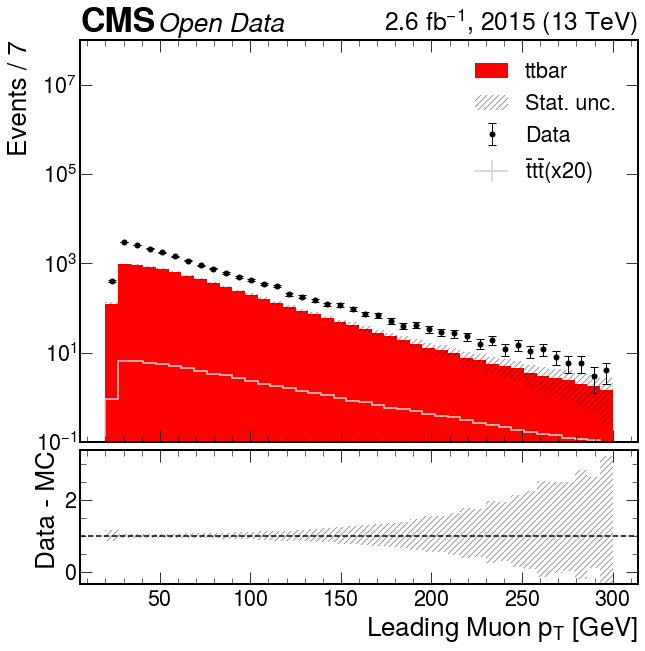

In [30]:
plotHisto(xlog=True)

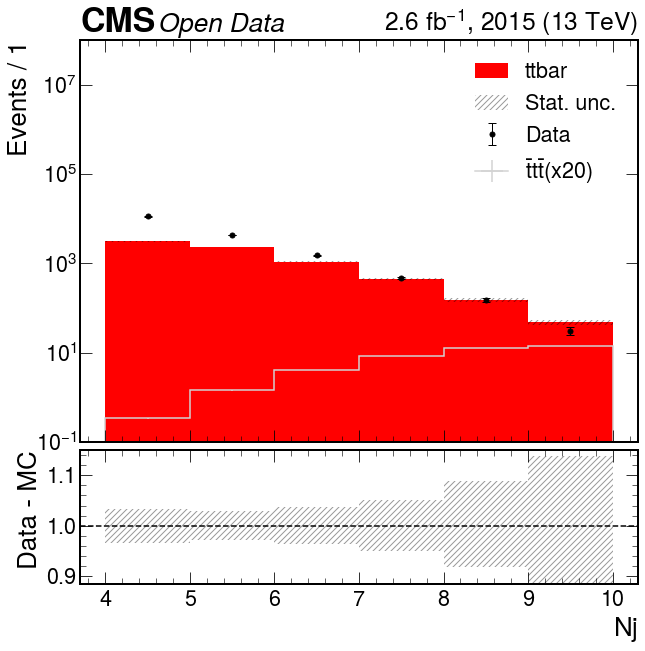

In [32]:
plotHisto(histName = "njets", xlabel = "$Nj$", rebinFactor = 1, xmin = 4.5j, xmax = 10j, mcFactor = 0.05)

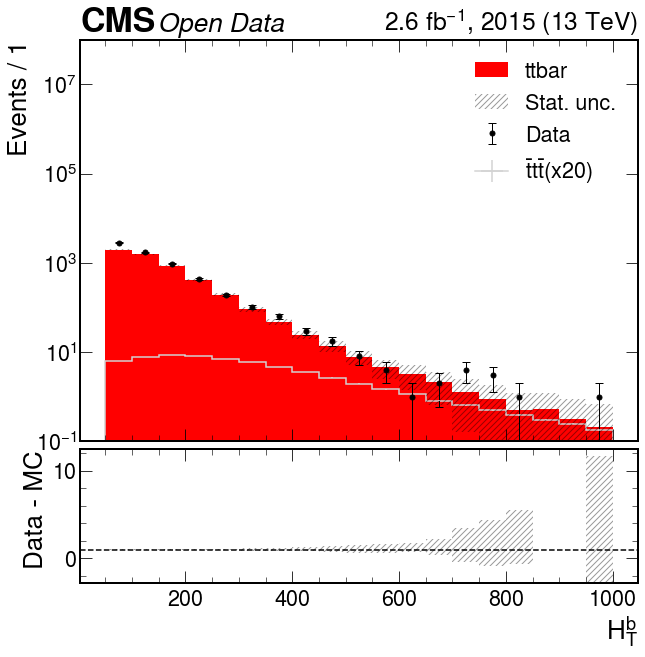

In [33]:
plotHisto(histName = "htb", xlabel = "$H_T^b$", rebinFactor = 1, xmin = 50j, xmax = 1000j, mcFactor = 0.05)

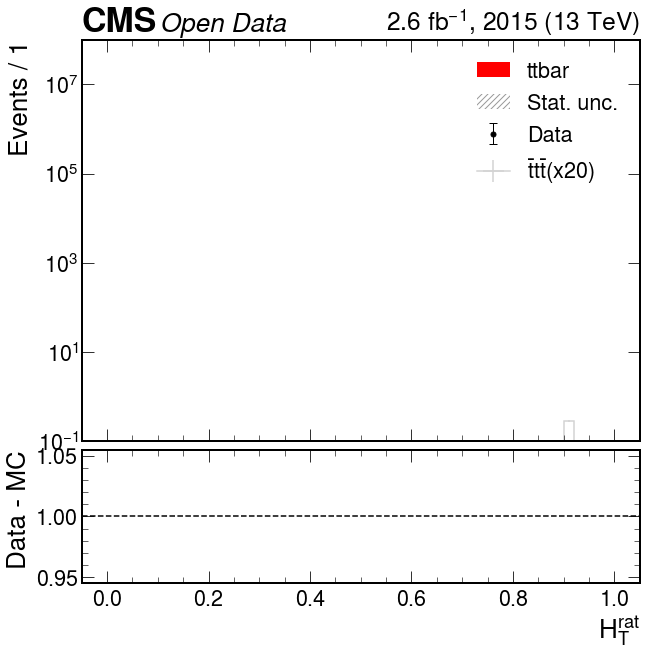

In [42]:
plotHisto(histName = "htrat", xlabel = "$H_T^{rat}$", rebinFactor = 1, xmin = 0j, xmax = 1j, mcFactor = 0.05)

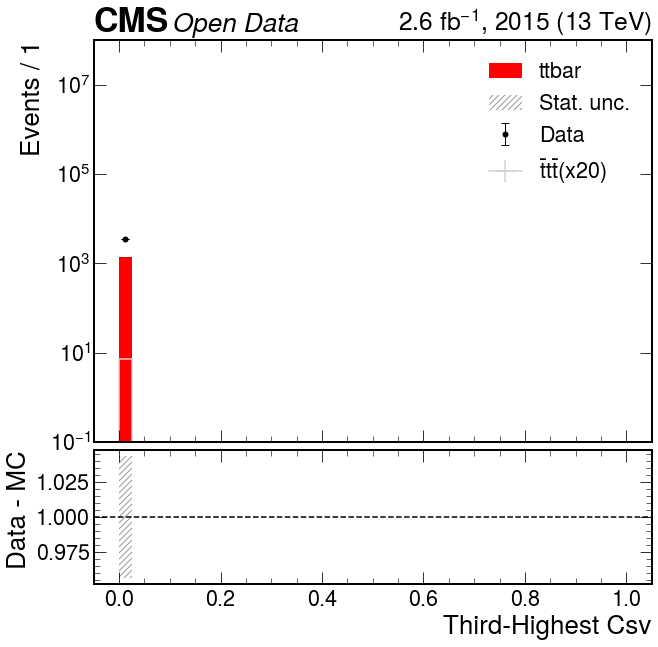

In [44]:
plotHisto(histName = "third_highest_csv", xlabel = "Third-Highest Csv", rebinFactor = 1, xmin = 0j, xmax = 1j, mcFactor = 0.05)

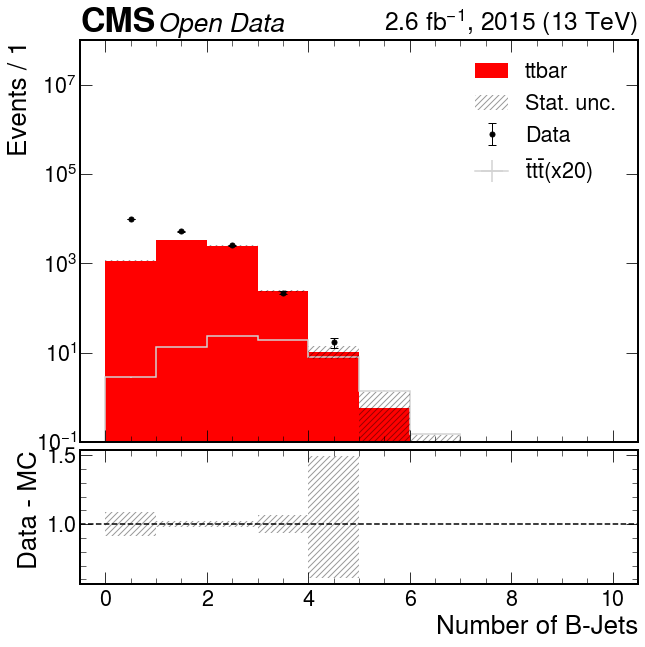

In [46]:
plotHisto(histName = "nbjets", xlabel = "Number of B-Jets", rebinFactor = 1, xmin = 0j, xmax = 10j, mcFactor = 0.05)

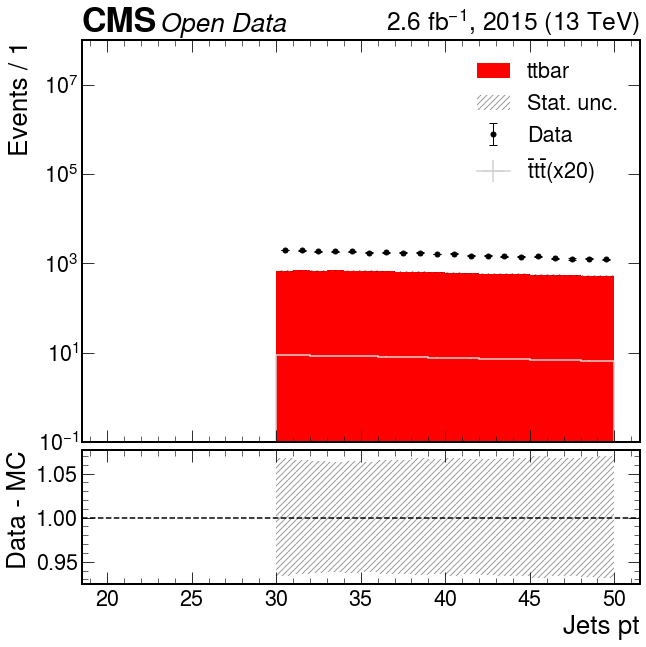

In [45]:
plotHisto(histName = "jets_pt", xlabel = "Jets pt", rebinFactor = 1, xmin = 20j, xmax = 50j, mcFactor = 0.05)